In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

from __future__ import division
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv
import numpy as np

<p style="font-family:courier;">1. Open the file with de zones and its features. We can select  Zonas_kmeans.csv or Zonas_dbscan.csv with the zones of differents clustering algorithms. We choose the results of DBScan due to the  results its graphic representation.</p>

In [2]:
file_name = '../Data/Zonas_dbscan.csv'

f = open(file_name, 'r')
csvfile = csv.reader(f)
caracteristicas = csvfile.next()[1:]
zonas = []

for zona in csvfile:
    zonas.append(map(int, zona))

<p style="font-family:courier;">2. Normalize the dataset</p>

In [3]:
min_max_scaler = MinMaxScaler()
zonas_norm = min_max_scaler.fit_transform([zona[1:] for zona in zonas])

<p style="font-family:courier;">3. Reduce the dimensionality of the data</p>

In [4]:
pca_estimator = PCA(n_components = 2)
X_pca = pca_estimator.fit_transform(zonas_norm)

print 'Varianza explicada por cada varaible: ' + str(pca_estimator.explained_variance_ratio_)
print 'Varianza total explicada: ' + str(sum(pca_estimator.explained_variance_ratio_))

Varianza explicada por cada varaible: [ 0.80022241  0.1217984 ]
Varianza total explicada: 0.922020811566


<p style="font-family:courier;">4. Plot the PCA</p>
<p style="font-family:courier;">4.1. Plot the raw results of the PCA</p>

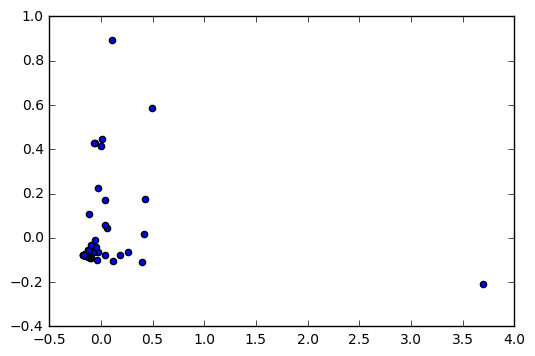

In [5]:
plt.scatter([x[0] for x in X_pca], [x[1] for x in X_pca])
plt.show()

<p style="font-family:courier;">4.2. Plot of the results centered in the core of points</p>

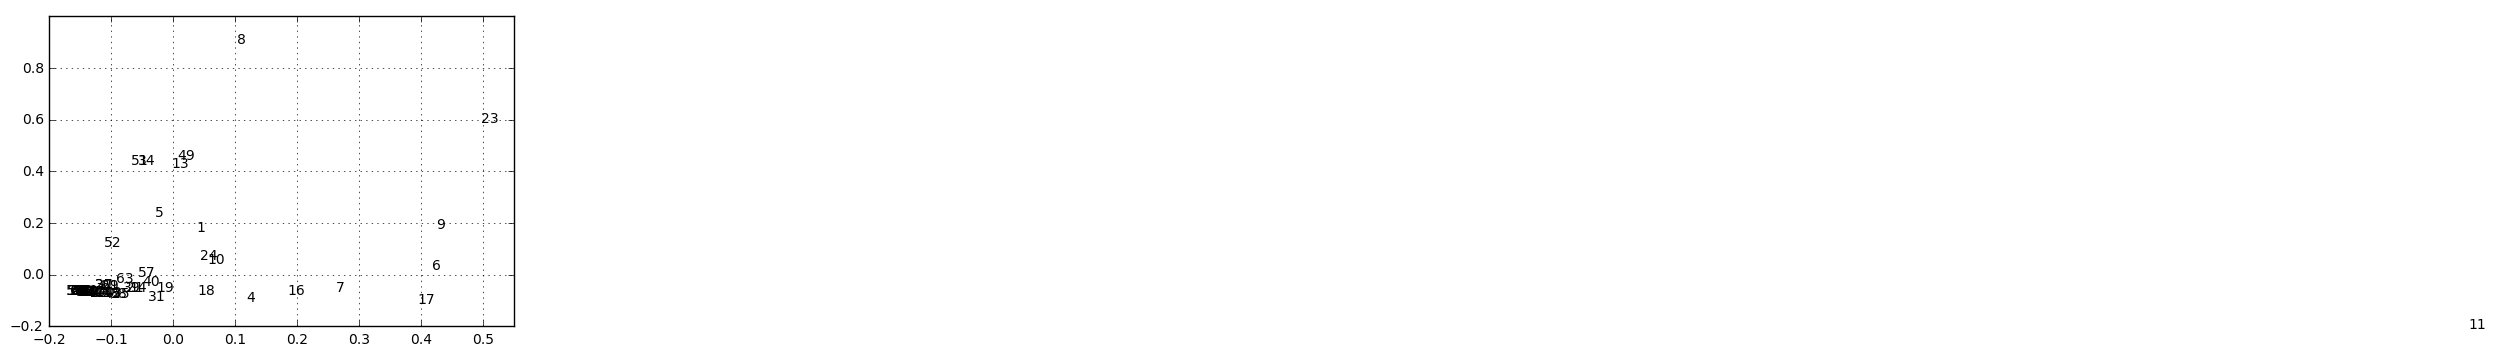

In [6]:
fig, ax = plt.subplots()
plt.xlim(-0.2, 0.55)
plt.ylim(-0.2, 1)
ax.grid(True)

N = len(X_pca)
numbers = np.arange(len(X_pca))

for i in range(N):
    plt.text(X_pca[i][0], X_pca[i][1], numbers[i])

plt.show()

<p style="font-family:courier;">5. Hierarchical clustering of the zones.</p>
<p style="font-family:courier;">5.1. Remove the zone 11 because it is a outlier and gets worse the dendogram</p>

In [7]:
import sklearn.neighbors
from scipy import cluster 

zona_peligrosa = zonas[11]
indice_out = 11
zonas = zonas[:11] + zonas[12:]
X_pca = np.concatenate((X_pca[:11], X_pca[12:]))

<p style="font-family:courier;">5.2. Calculate the distance matrix with Euclidean distance</p>

In [8]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(X_pca)

clusters = cluster.hierarchy.linkage(matsim, method = 'centroid')

<p style="font-family:courier;">6. Plot the dendogram with a threshold of 1.3 for visualize the clusters</p>

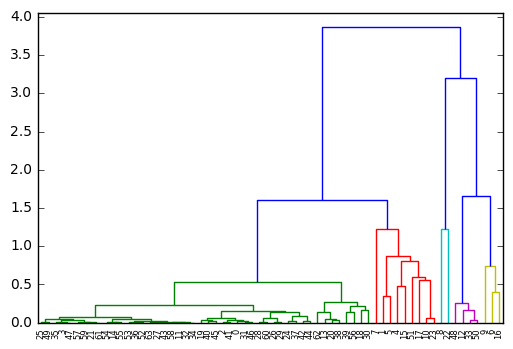

In [9]:
cluster.hierarchy.dendrogram(clusters, color_threshold=1.3)
plt.show()

<p style="font-family:courier;">7. Cut the dendogram in the distance of 1.3</p>

In [10]:
cut = 1.3
labels = cluster.hierarchy.fcluster(clusters, cut, criterion='distance')
unique_labels = set(labels)
print 'Número de clusters %d' % (len(unique_labels) + 1)

Número de clusters 6


<p style="font-family:courier;">8. Plot the results of the hierarchical clustering over the PCA points.</p>

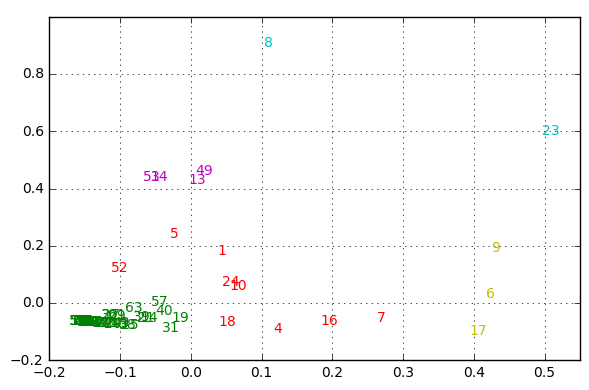

In [11]:
colors = np.array(list('bgrcmykbgrcmykbgrcmykbgrcmyk'))
colors = np.hstack([colors] * 20)

fig, ax = plt.subplots()

plt.xlim(-0.2, 0.55)
plt.ylim(-0.2, 1)
ax.grid(True)

for i in range(len(zonas)):
    plt.text(X_pca[i][0], X_pca[i][1], i if i < indice_out else i + 1, color = colors[labels[i]])

fig.tight_layout()
plt.show()

<p style="font-family:courier;">9. Characterize the obtain groups with maximum, minimum and average of the zones features of each group.</p>

In [12]:
zone_groups = dict()

for i, zona in enumerate(zonas):
    if labels[i] in zone_groups:
        zone_groups[labels[i]].append(zona)
    else:
        zone_groups[labels[i]] = [zona]
zone_groups[len(unique_labels)+1] = [zona_peligrosa]

features = []

for key in zone_groups:
    zone_feature = []
    for i in range(1, len(zone_groups[key][0])):
        feature = [zone[i] for zone in zone_groups[key]]
        maxi = max(feature)
        mini = min(feature)
        aver = sum(feature) / len(feature)
        zone_feature.append(maxi)
        zone_feature.append(mini)
        zone_feature.append(round(aver,2))
    features.append(zone_feature)

<p style="font-family:courier;">10. Save the results in a csv file</p>
<p style="font-family:courier;">10.1. We define five different groups of zones</p>

In [13]:
file_name_out = '../Data/Grupos_zonas.csv'

zonas_labels = ['Zona de peligro bajo',
                'Zona de peligro medio',  
                'Zona de peligro alto (Concentracion de accidentes de camiones)', 
                'Zona de peligro bajo (Concentracion de accidentes de camiones)', 
                'Zona de peligro alto',
                'Zona de peligro muy alto']

etiquetas = [' (max)', ' (min)', ' (average)']

with open(file_name_out, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    headers = ['Zona']
    for c in caracteristicas:
        for e in etiquetas:
            headers.append(c + e)
    writer.writerow(headers)
    
    for i, zone_feature in enumerate(features):
        zone_feature.insert(0, zonas_labels[i])
    writer.writerows(features)

In [14]:
file_name_out_2 = '../Data/Zonas_labels.csv'

headers = ['zona', 'accidentes', 'accidentes_alcance', 'accidentes_atropello',
          'accidentes_salida', 'accidentes_tijera_camion', 'accidentes_vuelco', 
            'accidentes_invierno', 'accidentes_primavera', 'accidentes_verano', 
           'accidentes_otoño', 'trafico_fluido', 'trafico_lento', 'trafico_muy_lento', 
          'trafico_parado','mañana(00:00-11:59)', 'tarde(12:00-23:59)', 'grupo']

for i in range(len(zonas)):
    zonas[i].append(labels[i])
zonas.append(zona_peligrosa + [6])

with open(file_name_out_2, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(headers)
    writer.writerows(zonas)